Edited by Clare Huang (Feb 7, 1:26 PM)

# Install the cartopy package for map plotting before starting jupyter
- In your terminal, install cartopy using conda
```
conda install -c scitools cartopy 
```

In [15]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date # This is to read .nc files and time marray
import numpy as np
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

# Load the data

In [16]:
filepath = '/home/csyhuang/ERAI/2007/2007_01-03_z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2012-09-17 21:28:18 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(240), latitude(121), levelist(37), time(360)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 levelist(levelist), int32 time(time), int16 z(time,levelist,latitude,longitude)
    groups: 

# Load the coordinates

In [17]:
xlon = fileobj.variables['longitude'][:]
ylat = fileobj.variables['latitude'][:]
plev = fileobj.variables['levelist'][:]
height = -7.*np.log(plev/1000.)

# Load the time coordinate

In [20]:
time = fileobj.variables['time'][:]
tunit = "hours since 1900-01-01T00:00:00Z" # This is true for Noboru's file but not necessarily the others
tarray = num2date(time,units = tunit,calendar = 'gregorian')
print('First five time stamps in the dataset: \n',tarray[:5]) # print the first 5 time stamps

First five time stamps in the dataset: 
 [datetime.datetime(2007, 1, 1, 0, 0) datetime.datetime(2007, 1, 1, 6, 0)
 datetime.datetime(2007, 1, 1, 12, 0) datetime.datetime(2007, 1, 1, 18, 0)
 datetime.datetime(2007, 1, 2, 0, 0)]


# Get the data on the layer p = 300hPa 

In [5]:
zlev = np.where(plev==300)[0][0] # get the layers with pressure = 300hPa
tstep = 0
print('zlev =',zlev)

# Get a snapshot of geopotential height at 300hpa at timestep = 0
geopotential_height = fileobj.variables['z'][tstep,zlev,:,:]/9.81 # shape = (121, 240)
print('Dimension of the geopotential height matrix: ' ,geopotential_height.shape)

zlev = 17
Dimension of the geopotential height matrix:  (121, 240)


# Demo: Plotting the geopotential height at 300hPa using two different projections
- Here I use the arrays *color_intervals* to set the color levels and *contour_intervals* to set the contour intervals.
- For better control of your plot appearance, google to find out what you can do with *contour*, *contourf*, and *matplotlib* axes.
- You can also choose a different projection from canopy, see examples from their [website](http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html).

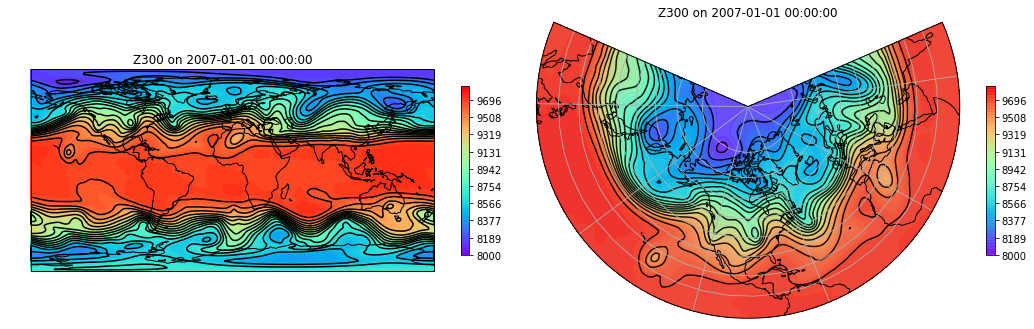

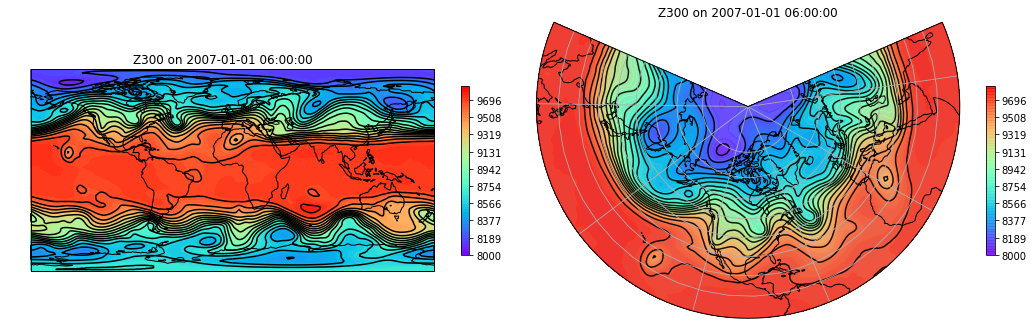

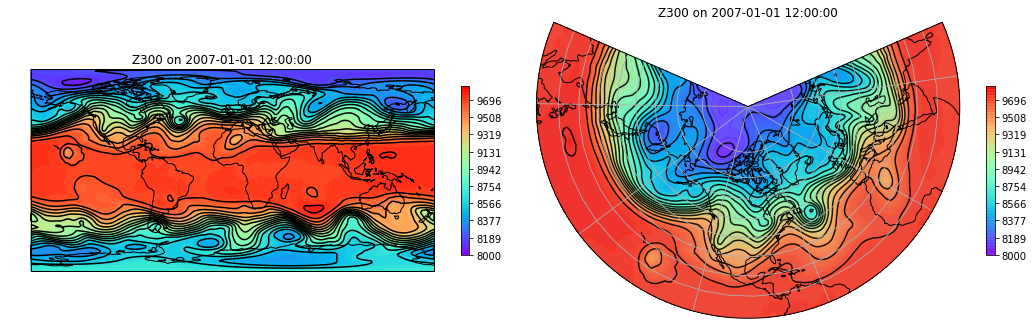

In [6]:
# Setting the contour levels for the colored plot
color_intervals = np.linspace(geopotential_height.min() * 0.99,
                              geopotential_height.max()*1.01, 60,
                              endpoint=True)

# Set the contour levels for the contour lines
contour_intervals = np.linspace(geopotential_height.min()*0.99,
                                geopotential_height.max()*1.01,
                                20,
                                endpoint=True)

for tstep in range(3): # looping over 3 time steps
    
    geopotential_height = fileobj.variables['z'][tstep,zlev,:,:]/9.81 # shape = (121, 240)
    timestamp = tarray[tstep]

    # Make the longitude coordinate cyclic (continuous at the booundary, connecting 0 deg to 360 deg)
    sst, lons = add_cyclic_point(geopotential_height, coord=xlon)

    plt.clf(); # clear the figure
    plt.figure(figsize=(15, 5));
    # Plot the figure on the left (1,2,1)
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree());
    plt.contourf(lons, ylat, sst, color_intervals, cmap='rainbow', transform=ccrs.PlateCarree())
    plt.title('Z300 on '+str(timestamp))
    plt.colorbar(shrink=0.5)
    plt.contour(lons, ylat, sst, contour_intervals, colors='k', transform=ccrs.PlateCarree())
    ax1.coastlines()

    # Plot the figure on the right (1,2,1)
    #ax2 = plt.subplot(1, 2, 2, projection=ccrs.AzimuthalEquidistant(central_latitude=90.0)); # This is another option to try
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.LambertConformal(central_latitude=90.0, cutoff=0));
    ax2.set_global()
    plt.contourf(lons, ylat, sst, color_intervals, cmap='rainbow', alpha=0.9, transform=ccrs.PlateCarree())
    plt.title('Z300 on '+str(timestamp))
    plt.colorbar(shrink=0.5)
    plt.contour(lons, ylat, sst, contour_intervals, colors='k', alpha=0.9, transform=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.gridlines()
    plt.tight_layout()
    
    # This saves the figure in the specific format.
    # The method zfill() pads string on the left with zeros to fill width.
    plt.savefig('test_'+str(tstep).zfill(3)+'.png')
    
    # If you don't want to show the graphic, comment out the line below
    plt.show()
    


# List the .png files in your directory
- When you include ! at the beginning of a line, you will execute the line as **linux commands**.
- The command below list out files with the '.png' suffix.

In [7]:
!ls *.png

test_000.png  test_001.png  test_002.png


# Running the jupyter notebook as a batch script (instead of having the window open)
You can convert the jupyter notebook to python script on linux command line:
```
jupyter nbconvert --to python Cartopy_tutorial.ipynb
```
This produces a file *Cartopy_tutorial.py*. When you execute a python script, make sure all the plots are not shown. **Remember to comment out all linux commands and ``` plt.show() ``` before converting.**

You can then run the python script in background on linux by using
```
python Cartopy_tutorial.py &
```
or if you want the output to be directed into a file
```
python Cartopy_tutorial.py > output_log 2>&1 &
```
See the [discussion](https://unix.stackexchange.com/questions/74520/can-i-redirect-output-to-a-log-file-and-background-a-process-at-the-same-time/74524) here for more explanation.


# Combine the images to make a movie
There are free software online that you may use to convert an image sequence to a movie, for example: http://www.andrewnoske.com/wiki/Convert_an_image_sequence_to_a_movie.

# Close the file if not used anymore

In [8]:
fileobj.close()